In [2]:
# ============================================================
# Clears workspace, clones LabelBench, installs dependencies
# ============================================================

!rm -rf /kaggle/working/*
!git clone https://github.com/EfficientTraining/LabelBench.git
!pip install -r /kaggle/working/LabelBench/requirements.txt
%cd /kaggle/working/LabelBench

Cloning into 'LabelBench'...
remote: Enumerating objects: 2858, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 2858 (delta 238), reused 283 (delta 178), pack-reused 2437 (from 1)
Receiving objects: 100% (2858/2858), 111.52 MiB | 35.00 MiB/s, done.
Resolving deltas: 100% (1481/1481), done.
Updating files: 100% (1415/1415), done.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tq1aepsd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tq1aepsd
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
ls

configs/        LabelBench/  mp_eval_launcher.py  README.md
docs/           LICENSE      mp_launcher.py       requirements.txt
example_run.sh  main.py      point_evaluation.py  results/


## Dataloader setup

In [4]:
import torch
import torch.nn.functional as F
from torchvision import datasets as tv_datasets, transforms
from torch.utils.data import Dataset
from LabelBench.skeleton.dataset_skeleton import register_dataset, LabelType, TransformDataset
import numpy as np

NUM_TASKS = 40   # Total number of incremental tasks


# ------------------------------------------------------------
# Dataset wrapper to expose only a subset of CIFAR-10 indices
# ------------------------------------------------------------
class CIFARStream(Dataset):
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds      # Full CIFAR-10 dataset
        self.indices = indices      # Indices assigned to this task

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Fetch the actual sample using stored indices
        x, y = self.base_ds[self.indices[idx]]
        return x, y


# ------------------------------------------------------------
# One-hot encoding helper (required by LabelBench)
# ------------------------------------------------------------
def one_hot(y, n=10):
    return F.one_hot(torch.tensor(y), num_classes=n).float()


# ------------------------------------------------------------
# Base dataset registry (intentionally disabled)
# ------------------------------------------------------------
@register_dataset("splitcifar10", LabelType.MULTI_CLASS)
def get_splitcifar10(_):
    # Prevent accidental usage of the base dataset
    raise RuntimeError("Use splitcifar10_<id>")


# ------------------------------------------------------------
# Build task stream ONCE (randomized split of CIFAR-10)
# ------------------------------------------------------------
base_train_global = tv_datasets.CIFAR10(root="./data", train=True, download=True)
all_idx = np.arange(len(base_train_global))
np.random.shuffle(all_idx)
stream_splits = np.array_split(all_idx, NUM_TASKS)


# ------------------------------------------------------------
# Register each task dynamically
# ------------------------------------------------------------
for split_id in range(NUM_TASKS):

    @register_dataset(f"splitcifar10_{split_id}", LabelType.MULTI_CLASS)
    def _make_split(data_dir, split_id=split_id):

        tf = transforms.Compose([transforms.ToTensor()])

        base_train = tv_datasets.CIFAR10(root=data_dir, train=True, download=True)
        base_test  = tv_datasets.CIFAR10(root=data_dir, train=False, download=True)

        
        # ----------------------------------------------------
        # TASK 0: Base session (only classes 0 and 1)
        # Fully supervised
        # ----------------------------------------------------
        if split_id == 0:
            indices = [i for i,(x,y) in enumerate(base_train) if y in [0,1]]
        else:
            # ------------------------------------------------
            # TASKS 1–19: Unlabeled streaming data
            # ------------------------------------------------
            indices = stream_splits[split_id]

        train_ds = CIFARStream(base_train, indices)

        # Wrap dataset with transforms + one-hot labels
        train_ds = TransformDataset(
            train_ds,
            transform=tf,
            target_transform=lambda y: one_hot(y,10)
        )

        test_ds = TransformDataset(
            base_test,
            transform=tf,
            target_transform=lambda y: one_hot(y,10)
        )

        return train_ds, test_ds, test_ds, None, None, None, 10, [str(i) for i in range(10)]

100%|██████████| 170M/170M [00:02<00:00, 77.8MB/s] 


## DATALOADER CHECKUP FOR UPTO 4 classes myself debugging to check represtations

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets as tv_datasets, transforms
from torch.utils.data import Dataset
from LabelBench.skeleton.dataset_skeleton import register_dataset, LabelType, TransformDataset
import numpy as np
from torch.utils.data import Subset


NUM_TASKS = 40
num_classes = 4


# ------------------------------------------------------------
# Dataset wrapper
# ------------------------------------------------------------
class CIFARStream(Dataset):
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        x, y = self.base_ds[self.indices[idx]]
        return x, y


# ------------------------------------------------------------
# One-hot encoding helper
# ------------------------------------------------------------
def one_hot(y, n=10):
    return F.one_hot(torch.tensor(y), num_classes=n).float()


# ------------------------------------------------------------
# Base dataset registry (disabled intentionally)
# ------------------------------------------------------------
@register_dataset("splitcifar10", LabelType.MULTI_CLASS)
def get_splitcifar10(_):
    raise RuntimeError("Use splitcifar10_<id>")


# ------------------------------------------------------------
# 🔥 BUILD FILTERED DATASET ONCE (IMPORTANT FIX)
# ------------------------------------------------------------
base_train_global = tv_datasets.CIFAR10(
    root="./data", train=True, download=True
)

selected_classes = [0, 1, 2, 3]   # airplane, automobile, bird, cat
targets_global = np.array(base_train_global.targets)
filtered_idx_global = np.where(np.isin(targets_global, selected_classes))[0]  #idxs of samples belonging to 0,1,2,3 class

# Now dataset size is 20000 (4 classes × 5000 each)
filtered_train_global = Subset(base_train_global, filtered_idx_global) #becomes a new dataset of length 4.

# Build stream splits FROM FILTERED DATASET
all_idx = np.arange(len(filtered_train_global))
np.random.shuffle(all_idx)
stream_splits = np.array_split(all_idx, NUM_TASKS)


# ------------------------------------------------------------
# Register each task dynamically
# ------------------------------------------------------------
for split_id in range(NUM_TASKS):

    @register_dataset(f"splitcifar10_{split_id}", LabelType.MULTI_CLASS)
    def _make_split(data_dir, split_id=split_id):

        tf = transforms.Compose([transforms.ToTensor()])

        # -------------------------
        # TRAIN DATA (filtered)
        # -------------------------
        base_train = tv_datasets.CIFAR10(
            root=data_dir, train=True, download=True
        )

        targets = np.array(base_train.targets)
        indices = np.where(np.isin(targets, selected_classes))[0]
        base_train = Subset(base_train, indices)

        # -------------------------
        # TEST DATA (filtered)
        # -------------------------
        base_test = tv_datasets.CIFAR10(
            root=data_dir, train=False, download=True
        )

        targets = np.array(base_test.targets)
        indices = np.where(np.isin(targets, selected_classes))[0]
        base_test = Subset(base_test, indices)

        # ----------------------------------------------------
        # TASK 0: Base session (only classes 0 and 1)
        # ----------------------------------------------------
        if split_id == 0:
            indices = [
                i for i, (x, y) in enumerate(base_train)
                if y in [0, 1]
            ]
        else:
            # Use filtered stream splits (FIXED)
            indices = stream_splits[split_id]

        train_ds = CIFARStream(base_train, indices)

        train_ds = TransformDataset(
            train_ds,
            transform=tf,
            target_transform=lambda y: one_hot(y, num_classes)
        )

        test_ds = TransformDataset(
            base_test,
            transform=tf,
            target_transform=lambda y: one_hot(y, num_classes)
        )

        return (
            train_ds,
            test_ds,
            test_ds,
            None,
            None,
            None,
            num_classes,
            [str(i) for i in range(num_classes)]
        )

## gpt fixing issues one by one no same class promotion (embedding will be passed to model)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]



================ TASK 0 ================
[INIT] Known classes: {'automobile', 'airplane'}

================ TASK 1 ================
[METRIC] Known-Class Acc = 0.977

================ TASK 2 ================
[METRIC] Known-Class Acc = 0.977

================ TASK 3 ================
[METRIC] Known-Class Acc = 0.977

================ TASK 4 ================
PROMOTED → deer
[METRIC] Known-Class Acc = 0.653

================ TASK 5 ================
[METRIC] Known-Class Acc = 0.659

================ TASK 6 ================
[METRIC] Known-Class Acc = 0.670

================ TASK 7 ================
[METRIC] Known-Class Acc = 0.679

================ TASK 8 ================
PROMOTED → dog
[METRIC] Known-Class Acc = 0.517

================ TASK 9 ================
[METRIC] Known-Class Acc = 0.522

================ TASK 10 ================
[METRIC] Known-Class Acc = 0.531

================ TASK 11 ================
[METRIC] Known-Class Acc = 0.540

================ TASK 12 ================
[METRIC]

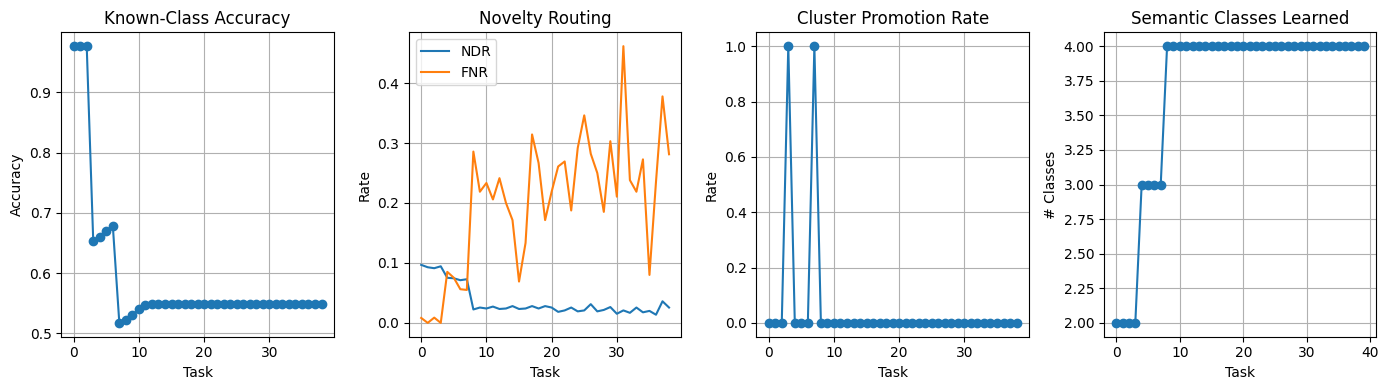

In [5]:
# ============================================================
# OPEN-WORLD LEARNING WITH CLASS DISCOVERY + METRICS
# ============================================================
# This script implements an open-world continual learning setup:
#
# 1. Train initially on known classes.
# 2. Detect novel samples using hypersphere-based boundaries.
# 3. Accumulate high-novelty samples in a buffer.
# 4. Periodically cluster novel samples.
# 5. Validate clusters using unsupervised criteria.
# 6. Promote valid clusters to new classes.
# 7. Expand classifier head dynamically.
# 8. Fine-tune while replaying old class memory.
# 9. Track multiple evaluation metrics.
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import DataLoader, TensorDataset
import hdbscan
from torchvision.models import resnet18
from LabelBench.skeleton.dataset_skeleton import datasets as DATASET_REGISTRY


# ============================================================
# CONFIGURATION
# ============================================================

NUM_TASKS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Cluster validation thresholds
COH_THR = 0.25
SEP_THR = 0.15
P = 4                      # perform clustering every P tasks
TOPK_NOVELTY = 120         # top novel samples per task
MAX_NOVELTY_BUFFER = 500   # maximum buffer size
MIN_CLUSTER_SIZE = 50      # minimum cluster size for promotion

# Unsupervised cluster validation parameters
ALPHA = 0.25   # intra-cluster compactness threshold
BETA = 0.35    # separation from known classes threshold
GAMMA = 0.30
DELTA = 80     # density threshold


# ============================================================
# CIFAR-10 LABEL MAP
# ============================================================

CIFAR10_LABELS = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
    4: "deer", 5: "dog", 6: "frog", 7: "horse",
    8: "ship", 9: "truck"
}


# ============================================================
# MODEL DEFINITION
# ============================================================

class CNN(nn.Module):
    """
    Model architecture:
    - Pretrained ResNet18 backbone
    - Final FC layer removed
    - Projection layer (512 → 256)
    - Classifier head (256 → num_classes)
    """

    def __init__(self, num_classes):
        super().__init__()

        base = resnet18(pretrained=True)

        # Remove the final fully connected layer
        self.encoder = nn.Sequential(*list(base.children())[:-1])

        # Projection layer to embedding space
        self.embed = nn.Linear(512, 256)

        # Classification head
        self.classifier = nn.Linear(256, num_classes)

    def expand_head(self, new_classes):
        """
        Expand classifier head while preserving existing weights.
        """

        old_w = self.classifier.weight.data.clone()
        old_b = self.classifier.bias.data.clone()
        old_n = old_w.shape[0]

        self.classifier = nn.Linear(256, new_classes)

        # Copy old class weights
        self.classifier.weight.data[:old_n] = old_w
        self.classifier.bias.data[:old_n] = old_b

    def forward(self, x):

        # Extract deep features
        z = self.encoder(x).squeeze()

        # Project to embedding space
        z = self.embed(z)

        # Normalize embeddings (unit hypersphere)
        z = F.normalize(z, dim=1)

        # Compute logits
        logits = self.classifier(z)

        return logits, z


# ============================================================
# MEMORY BUFFER
# ============================================================

class MemoryBuffer:
    """
    Stores a limited number of representative embeddings
    per known class.
    """

    def __init__(self, max_per_class=80):
        self.data = defaultdict(list)
        self.max_per_class = max_per_class

    def add_batch(self, Z, y):
        """
        Add embeddings for a class and keep only the most central ones.
        """
        for z in Z:
            self.data[int(y)].append(z.detach().cpu())
        self._reduce(y)

    def _reduce(self, y):
        """
        Keep only embeddings closest to the class centroid.
        """
        Z = self.data[int(y)]

        if len(Z) <= self.max_per_class:
            return

        Z = torch.stack(Z)
        mu = F.normalize(Z.mean(0), dim=0)

        # Cosine distance from centroid
        d = 1 - torch.matmul(Z, mu)

        idx = torch.argsort(d)[:self.max_per_class]
        self.data[int(y)] = [Z[i] for i in idx]

    def get(self):
        return self.data


# ============================================================
# HYPERSPHERE NOVELTY DETECTOR
# ============================================================

class HypersphereNovelty:
    """
    Each known class is represented by:
    - A centroid (mean embedding)
    - A radius (quantile of distances)
    """

    def __init__(self, q=0.95):
        self.q = q
        self.mu, self.r = {}, {}

    def update(self, memory):
        """
        Recompute class centroids and radii
        from memory buffer.
        """
        self.mu, self.r = {}, {}

        for k, Z in memory.items():
            Z = torch.stack(Z)
            mu = F.normalize(Z.mean(0), dim=0)
            d = 1 - torch.matmul(Z, mu)

            self.mu[k] = mu
            self.r[k] = torch.quantile(d, self.q)

    def score(self, z):
        """
        Compute novelty score:
        distance from closest class hypersphere boundary.
        """
        return min([
            (1 - torch.dot(z.cpu(), self.mu[k])) - self.r[k]
            for k in self.mu
        ])


# ============================================================
# SUPERVISED TRAINING (INITIAL TASK)
# ============================================================

def train_supervised(model, loader):

    opt = torch.optim.Adam(model.parameters(), 1e-4)
    model.train()

    for _ in range(15):
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)

            loss = F.cross_entropy(model(x)[0], y)

            opt.zero_grad()
            loss.backward()
            opt.step()


# ============================================================
# PROTOTYPE LOSS
# ============================================================

def prototype_loss(z, y, detector):
    """
    Encourages embeddings to stay close to class centroids.
    """

    if len(detector.mu) == 0:
        return torch.tensor(0.0, device=z.device)

    loss = 0.0
    count = 0

    for i in range(len(z)):
        cls = int(y[i].item())

        if cls in detector.mu:
            mu = detector.mu[cls].to(z.device)
            loss += 1 - torch.dot(z[i], mu)
            count += 1

    if count == 0:
        return torch.tensor(0.0, device=z.device)

    return loss / count


# ============================================================
# FINE-TUNING AFTER CLASS PROMOTION
# ============================================================

def finetune(model, memory, Z_new, new_label, detector):

    model.train()

    # Freeze all parameters
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze only last ResNet block + embedding + classifier
    for name, p in model.encoder.named_parameters():
        if "layer4" in name:
            p.requires_grad = True

    for p in model.embed.parameters():
        p.requires_grad = True

    for p in model.classifier.parameters():
        p.requires_grad = True

    # Build balanced replay dataset
    X, Y = [], []

    min_count = min(len(v) for v in memory.values())

    for cls, Zs in memory.items():
        for z in Zs[:min_count]:
            X.append(z)
            Y.append(cls)

    for z in Z_new:
        X.append(z.cpu())
        Y.append(new_label)

    X = torch.stack(X).to(DEVICE)
    Y = torch.tensor(Y).to(DEVICE)

    opt = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4
    )

    for _ in range(30):

        X_norm = F.normalize(X, dim=1)
        logits = model.classifier(X_norm)

        loss_ce = F.cross_entropy(logits, Y)
        loss_proto = prototype_loss(X, Y, detector)
        loss = loss_ce + 0.4 * loss_proto

        opt.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(
            filter(lambda p: p.requires_grad, model.parameters()),
            max_norm=5.0
        )

        opt.step()

    model.eval()


# ============================================================
# REHEARSAL FOR OLD CLASSES
# ============================================================

def rehearse(model, memory):

    if not memory.get():
        return

    model.train()

    X, Y = [], []

    for cls, Zs in memory.get().items():
        for z in Zs:
            X.append(z)
            Y.append(cls)

    X = torch.stack(X).to(DEVICE)
    Y = torch.tensor(Y).to(DEVICE)

    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)

    opt = torch.optim.Adam(
        list(model.embed.parameters()) +
        list(model.classifier.parameters()),
        lr=5e-4
    )

    for _ in range(30):
        for xb, yb in loader:

            xb_norm = F.normalize(xb, dim=1)
            logits = model.classifier(xb_norm)

            loss = F.cross_entropy(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()


# ============================================================
# METRIC STORAGE
# ============================================================

task_kca, task_ndr, task_fnr, task_cpr = [], [], [], []
learned_classes_over_time = []
promoted_classes_log = []


# ============================================================
# MAIN CONTINUAL LEARNING LOOP
# ============================================================

TASKS = [f"splitcifar10_{i}" for i in range(NUM_TASKS)]

model = CNN(num_classes=2).to(DEVICE)
memory = MemoryBuffer()
detector = HypersphereNovelty()
novelty_buffer = []

semantic_to_internal = {0: 0, 1: 1}
internal_to_semantic = {0: 0, 1: 1}
known_classes = 2


for t, task in enumerate(TASKS):

    print(f"\n================ TASK {t} ================")

    _, dataset_fn = DATASET_REGISTRY[task]
    train_ds, test_ds, *_ = dataset_fn("./data")
    loader = DataLoader(train_ds, batch_size=64, shuffle=False)

    # Initial supervised training
    if t == 0:
        train_supervised(model, loader)

        with torch.no_grad():
            for x, y in loader:
                _, z = model(x.to(DEVICE))
                y = y.argmax(1)

                for cls in torch.unique(y):
                    memory.add_batch(z[y == cls], cls.item())

        detector.update(memory.get())

        learned_classes_over_time.append(
            {CIFAR10_LABELS[c] for c in set(y.tolist())}
        )

        print(f"[INIT] Known classes: {learned_classes_over_time[-1]}")
        continue

    # Rehearsal for stability
    rehearse(model, memory)
    model.eval()

    novelty_candidates = []
    novel, false_novel, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:

            _, z = model(x.to(DEVICE))
            y = y.argmax(1)

            scores = [detector.score(z[i]) for i in range(len(z))]

            base_thr = np.percentile(scores, 90)
            thr = base_thr + 0.01 * known_classes

            for i in range(len(z)):
                total += 1
                if scores[i] > thr:
                    novelty_candidates.append(
                        (scores[i], z[i].cpu(), y[i].item())
                    )
                    novel += 1

                    if y[i].item() < known_classes:
                        false_novel += 1

    task_ndr.append(novel / max(total, 1))
    task_fnr.append(false_novel / max(novel, 1))

    novelty_candidates.sort(reverse=True, key=lambda x: x[0])

    novelty_buffer.extend([
        (z, y) for _, z, y in novelty_candidates[:TOPK_NOVELTY]
    ])

    novelty_buffer = novelty_buffer[-MAX_NOVELTY_BUFFER:]

    # Periodic clustering
    if t % P == 0:

        Z = np.stack([z.numpy() for z, _ in novelty_buffer])

        labels = hdbscan.HDBSCAN(
            metric='euclidean',
            min_cluster_size=10
        ).fit_predict(Z)

        new_buffer = []
        found, promoted = 0, 0

        for cid in sorted(set(labels)):

            if promoted >= 1:
                break

            idxs = np.where(labels == cid)[0]

            if cid == -1:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])
                continue

            found += 1

            Zc = torch.stack([novelty_buffer[i][0] for i in idxs])
            mu = F.normalize(Zc.mean(0), dim=0)

            n = len(idxs)
            S_intra = torch.mean(1 - torch.matmul(Zc, mu))

            if len(detector.mu) > 0:
                S_known = min([
                    1 - torch.dot(mu, detector.mu[k].to(mu.device))
                    for k in detector.mu
                ])
            else:
                S_known = torch.tensor(1.0)

            density = n / (S_intra.item() + 1e-6)

            labels_true = [novelty_buffer[i][1] for i in idxs]
            dist = Counter(labels_true)

            sem_label, cnt = dist.most_common(1)[0]
            purity = cnt / len(labels_true)

            if sem_label in semantic_to_internal:
                continue

            if (
                S_intra <= ALPHA and
                density >= DELTA and
                S_known >= BETA and
                n >= MIN_CLUSTER_SIZE
            ):

                promoted += 1
                new_label = known_classes

                semantic_to_internal[sem_label] = new_label
                internal_to_semantic[new_label] = sem_label
                known_classes += 1

                model.expand_head(known_classes)
                model.to(DEVICE)

                finetune(model, memory.get(), Zc, new_label, detector)
                memory.add_batch(Zc, new_label)

                promoted_classes_log.append({
                    "task": t,
                    "semantic": CIFAR10_LABELS[sem_label],
                    "purity": purity
                })

                print(f"PROMOTED → {CIFAR10_LABELS[sem_label]}")

            else:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])

        novelty_buffer = new_buffer

        task_cpr.append(promoted / max(found, 1))
        detector.update(memory.get())

    else:
        task_cpr.append(0.0)

    learned_classes_over_time.append(
        set(learned_classes_over_time[-1]) |
        {p["semantic"] for p in promoted_classes_log if p["task"] == t}
    )

    # Known-class accuracy evaluation
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in DataLoader(test_ds, batch_size=128):

            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)

            logits, _ = model(x)
            preds = logits.argmax(1)

            for i in range(len(y)):

                sem = int(y[i])

                if sem in semantic_to_internal:

                    internal_gt = semantic_to_internal[sem]

                    if preds[i].item() == internal_gt:
                        correct += 1

                    total += 1

    acc = correct / max(total, 1)
    task_kca.append(acc)

    print(f"[METRIC] Known-Class Acc = {acc:.3f}")


# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n===== FINAL DISCOVERY SUMMARY =====")
print("Initial classes:", learned_classes_over_time[0])
print("Final learned classes:", learned_classes_over_time[-1])

print("\nPromoted classes timeline:")
for p in promoted_classes_log:
    print(f"Task {p['task']:02d} → {p['semantic']} (purity={p['purity']:.2f})")


# ============================================================
# PLOTS
# ============================================================

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(task_kca, marker='o')
plt.title("Known-Class Accuracy")
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1,4,2)
plt.plot(task_ndr, label="NDR")
plt.plot(task_fnr, label="FNR")
plt.title("Novelty Routing")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)

plt.subplot(1,4,3)
plt.plot(task_cpr, marker='o')
plt.title("Cluster Promotion Rate")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.grid(True)

plt.subplot(1,4,4)
plt.plot([len(s) for s in learned_classes_over_time], marker='o')
plt.title("Semantic Classes Learned")
plt.xlabel("Task")
plt.ylabel("# Classes")
plt.grid(True)

plt.tight_layout()
plt.show()


## gpt fixing issue 2 using storing raw images and encoder not frozee

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



================ TASK 0 ================
[INIT] Known classes: {'automobile', 'airplane'}

================ TASK 1 ================
[METRIC] Known-Class Acc = 0.936

================ TASK 2 ================
[METRIC] Known-Class Acc = 0.924

================ TASK 3 ================
[METRIC] Known-Class Acc = 0.940

================ TASK 4 ================
Cluster stats → n=86, S_intra=0.019, S_known=0.266, density=4461.4
PROMOTED → bird
[METRIC] Known-Class Acc = 0.630

================ TASK 5 ================
[METRIC] Known-Class Acc = 0.799

================ TASK 6 ================
[METRIC] Known-Class Acc = 0.783

================ TASK 7 ================
[METRIC] Known-Class Acc = 0.788

================ TASK 8 ================
Cluster stats → n=25, S_intra=0.014, S_known=0.462, density=1764.6
[METRIC] Known-Class Acc = 0.747

================ TASK 9 ================
[METRIC] Known-Class Acc = 0.754

================ TASK 10 ================
[METRIC] Known-Class Acc = 0.779

=======

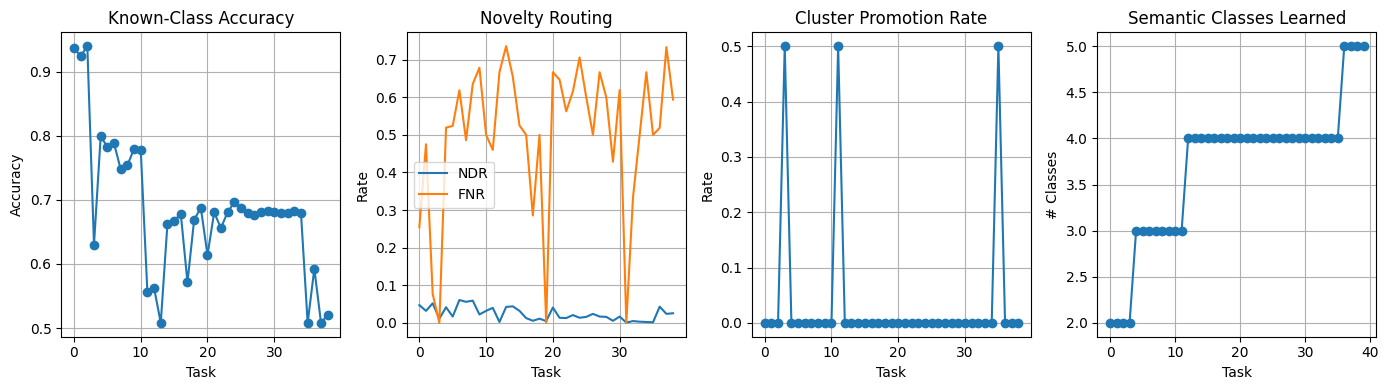

In [6]:
# ============================================================
# OPEN-WORLD LEARNING WITH CLASS DISCOVERY + METRICS
# ============================================================
# This implementation performs open-world continual learning:
#
# 1. Train initially on known classes.
# 2. Store raw images in memory for replay.
# 3. Use hypersphere-based novelty detection in embedding space.
# 4. Accumulate high-novelty samples.
# 5. Periodically cluster novel samples using HDBSCAN.
# 6. Validate clusters using unsupervised geometric criteria.
# 7. Promote valid clusters to new classes.
# 8. Expand classifier head dynamically.
# 9. Fine-tune model using full replay + prototype regularization.
# 10. Track discovery and accuracy metrics across tasks.
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import DataLoader
import hdbscan
from torchvision.models import resnet18
from LabelBench.skeleton.dataset_skeleton import datasets as DATASET_REGISTRY


# ============================================================
# CONFIGURATION
# ============================================================

NUM_TASKS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

COH_THR = 0.25
SEP_THR = 0.15
P = 4                          # Perform clustering every P tasks
TOPK_NOVELTY = 120             # Keep top novel samples per task
MAX_NOVELTY_BUFFER = 500       # Maximum buffer size
MIN_CLUSTER_SIZE = 50          # Initial definition (overridden below)

# Updated cluster validation thresholds
ALPHA = 0.35                   # Intra-cluster compactness threshold
BETA = 0.25                    # Separation from known classes threshold
DELTA = 40                     # Density threshold
MIN_CLUSTER_SIZE = 30          # Minimum cluster size for promotion


# ============================================================
# CIFAR-10 LABEL MAP
# ============================================================

CIFAR10_LABELS = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
    4: "deer", 5: "dog", 6: "frog", 7: "horse",
    8: "ship", 9: "truck"
}


# ============================================================
# MODEL DEFINITION
# ============================================================

class CNN(nn.Module):
    """
    Architecture:
    - Pretrained ResNet18 backbone
    - Remove final fully connected layer
    - Projection layer (512 → 256)
    - Normalized embedding
    - Classification head
    """

    def __init__(self, num_classes):
        super().__init__()

        base = resnet18(pretrained=True)

        # Remove final fully connected layer
        self.encoder = nn.Sequential(*list(base.children())[:-1])

        # Projection layer to embedding space
        self.embed = nn.Linear(512, 256)

        # Classifier head
        self.classifier = nn.Linear(256, num_classes)

    def expand_head(self, new_classes):
        """
        Expand classifier head while preserving learned weights.
        """

        old_w = self.classifier.weight.data.clone()
        old_b = self.classifier.bias.data.clone()
        old_n = old_w.shape[0]

        self.classifier = nn.Linear(256, new_classes)

        self.classifier.weight.data[:old_n] = old_w
        self.classifier.bias.data[:old_n] = old_b

    def forward(self, x):

        # Extract deep features
        z = self.encoder(x)

        # Preserve batch dimension
        z = z.view(z.size(0), -1)

        # Project to embedding space
        z = self.embed(z)

        # Normalize embeddings
        z = F.normalize(z, dim=1)

        # Compute class logits
        logits = self.classifier(z)

        return logits, z


# ============================================================
# MEMORY BUFFER (Stores RAW IMAGES)
# ============================================================

class MemoryBuffer:
    """
    Stores raw images per class for replay.
    """

    def __init__(self, max_per_class=80):
        self.data = defaultdict(list)
        self.max_per_class = max_per_class

    def add_batch(self, X, y):
        """
        Add raw images for a specific class.
        """
        for x in X:
            self.data[int(y)].append(x.detach().cpu())

        # Keep only limited samples per class
        if len(self.data[int(y)]) > self.max_per_class:
            self.data[int(y)] = self.data[int(y)][:self.max_per_class]

    def get(self):
        return self.data


# ============================================================
# HYPERSPHERE NOVELTY DETECTOR
# ============================================================

class HypersphereNovelty:
    """
    Each class is represented by:
    - Centroid in embedding space
    - Radius determined by quantile distance
    """

    def __init__(self, q=0.95):
        self.q = q
        self.mu, self.r = {}, {}

    def update(self, memory, model):
        """
        Recompute centroids and radii using live embeddings.
        """

        self.mu, self.r = {}, {}

        for k, X in memory.items():

            X = torch.stack(X).to(DEVICE)

            with torch.no_grad():
                _, Z = model(X)

            mu = F.normalize(Z.mean(0), dim=0)
            d = 1 - torch.matmul(Z, mu)

            self.mu[k] = mu
            self.r[k] = torch.quantile(d, self.q)

    def score(self, z):
        """
        Novelty score based on distance from nearest hypersphere boundary.
        """

        return min([
            (1 - torch.dot(z, self.mu[k].to(z.device)))
            - self.r[k].to(z.device)
            for k in self.mu
        ])


# ============================================================
# INITIAL SUPERVISED TRAINING
# ============================================================

def train_supervised(model, loader):

    opt = torch.optim.Adam(model.parameters(), 1e-4)
    model.train()

    for _ in range(15):
        for x, y in loader:

            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)

            loss = F.cross_entropy(model(x)[0], y)

            opt.zero_grad()
            loss.backward()
            opt.step()


# ============================================================
# PROTOTYPE REGULARIZATION LOSS
# ============================================================

def prototype_loss(z, y, detector):

    if len(detector.mu) == 0:
        return torch.tensor(0.0, device=z.device)

    loss = 0.0
    count = 0

    for i in range(len(z)):
        cls = int(y[i].item())

        if cls in detector.mu:
            mu = detector.mu[cls].to(z.device)
            loss += 1 - torch.dot(z[i], mu)
            count += 1

    if count == 0:
        return torch.tensor(0.0, device=z.device)

    return loss / count


# ============================================================
# FINETUNING AFTER CLASS PROMOTION
# ============================================================

def finetune(model, memory, X_new, new_label, detector):

    model.train()

    for p in model.parameters():
        p.requires_grad = True

    X_all, Y_all = [], []

    min_count = min(len(v) for v in memory.values())

    for cls, Xs in memory.items():
        for x in Xs[:min_count]:
            X_all.append(x)
            Y_all.append(cls)

    for x in X_new:
        X_all.append(x.cpu())
        Y_all.append(new_label)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=1e-4)

    for _ in range(30):

        logits, Z = model(X_all)

        loss_ce = F.cross_entropy(logits, Y_all)
        loss_proto = prototype_loss(Z, Y_all, detector)

        loss = loss_ce + 0.5 * loss_proto

        opt.zero_grad()
        loss.backward()
        opt.step()

    model.eval()


# ============================================================
# REHEARSAL FOR STABILITY
# ============================================================

def rehearse(model, memory):

    if not memory.get():
        return

    model.train()

    X_all, Y_all = [], []

    for cls, Xs in memory.get().items():
        for x in Xs:
            X_all.append(x)
            Y_all.append(cls)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=5e-4)

    for _ in range(20):

        logits, _ = model(X_all)
        loss = F.cross_entropy(logits, Y_all)

        opt.zero_grad()
        loss.backward()
        opt.step()


# ============================================================
# METRIC STORAGE
# ============================================================

task_kca, task_ndr, task_fnr, task_cpr = [], [], [], []
learned_classes_over_time = []
promoted_classes_log = []


# ============================================================
# MAIN CONTINUAL LEARNING LOOP
# ============================================================

TASKS = [f"splitcifar10_{i}" for i in range(NUM_TASKS)]

model = CNN(num_classes=2).to(DEVICE)
memory = MemoryBuffer()
detector = HypersphereNovelty()

novelty_buffer = []

semantic_to_internal = {0: 0, 1: 1}
internal_to_semantic = {0: 0, 1: 1}
known_classes = 2


for t, task in enumerate(TASKS):

    print(f"\n================ TASK {t} ================")

    _, dataset_fn = DATASET_REGISTRY[task]
    train_ds, test_ds, *_ = dataset_fn("./data")
    loader = DataLoader(train_ds, batch_size=64, shuffle=False)

    # Initial supervised training
    if t == 0:

        train_supervised(model, loader)

        with torch.no_grad():
            for x, y in loader:
                y = y.argmax(1)
                for cls in torch.unique(y):
                    memory.add_batch(x[y == cls], cls.item())

        detector.update(memory.get(), model)

        learned_classes_over_time.append(
            {CIFAR10_LABELS[c] for c in set(y.tolist())}
        )

        print(f"[INIT] Known classes: {learned_classes_over_time[-1]}")
        continue

    rehearse(model, memory)
    model.eval()

    novelty_candidates = []
    novel, false_novel, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:

            _, z = model(x.to(DEVICE))
            y = y.argmax(1)

            scores = [detector.score(z[i]).item() for i in range(len(z))]

            base_thr = np.percentile(scores, 90)
            thr = base_thr + 0.01 * known_classes

            for i in range(len(z)):
                total += 1
                if scores[i] > thr:
                    novelty_candidates.append(
                        (scores[i], x[i].cpu(), y[i].item())
                    )
                    novel += 1
                    if y[i].item() < known_classes:
                        false_novel += 1

    task_ndr.append(novel / max(total, 1))
    task_fnr.append(false_novel / max(novel, 1))

    novelty_candidates.sort(reverse=True, key=lambda x: x[0])

    novelty_buffer.extend([
        (img, y) for _, img, y in novelty_candidates[:TOPK_NOVELTY]
    ])

    novelty_buffer = novelty_buffer[-MAX_NOVELTY_BUFFER:]

    # Periodic clustering
    if t % P == 0:

        Z = []

        with torch.no_grad():
            for img, _ in novelty_buffer:
                _, z = model(img.unsqueeze(0).to(DEVICE))
                Z.append(z.squeeze().cpu().numpy())

        Z = np.stack(Z)

        labels = hdbscan.HDBSCAN(
            metric='euclidean',
            min_cluster_size=10
        ).fit_predict(Z)

        new_buffer = []
        found, promoted = 0, 0

        for cid in sorted(set(labels)):

            idxs = np.where(labels == cid)[0]

            if cid == -1:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])
                continue

            found += 1

            Xc = torch.stack([novelty_buffer[i][0] for i in idxs])

            with torch.no_grad():
                _, Zc = model(Xc.to(DEVICE))

            mu = F.normalize(Zc.mean(0), dim=0)
            n = len(idxs)
            S_intra = torch.mean(1 - torch.matmul(Zc, mu))

            if len(detector.mu) > 0:
                S_known = min([
                    1 - torch.dot(mu, detector.mu[k].to(mu.device))
                    for k in detector.mu
                ])
            else:
                S_known = torch.tensor(1.0)

            density = n / (S_intra.item() + 1e-6)

            labels_true = [novelty_buffer[i][1] for i in idxs]
            sem_label, cnt = Counter(labels_true).most_common(1)[0]
            purity = cnt / len(labels_true)

            if sem_label in semantic_to_internal:
                continue

            print(
                f"Cluster stats → "
                f"n={n}, "
                f"S_intra={S_intra.item():.3f}, "
                f"S_known={S_known.item():.3f}, "
                f"density={density:.1f}"
            )

            if (
                S_intra <= ALPHA and
                density >= DELTA and
                S_known >= BETA and
                n >= MIN_CLUSTER_SIZE
            ):

                promoted += 1
                new_label = known_classes

                semantic_to_internal[sem_label] = new_label
                internal_to_semantic[new_label] = sem_label
                known_classes += 1

                model.expand_head(known_classes)
                model.to(DEVICE)

                finetune(model, memory.get(), Xc, new_label, detector)
                memory.add_batch(Xc, new_label)

                detector.update(memory.get(), model)

                promoted_classes_log.append({
                    "task": t,
                    "semantic": CIFAR10_LABELS[sem_label],
                    "purity": purity
                })

                print(f"PROMOTED → {CIFAR10_LABELS[sem_label]}")

            else:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])

        novelty_buffer = new_buffer
        task_cpr.append(promoted / max(found, 1))

    else:
        task_cpr.append(0.0)

    # ========================================================
    # TASK-WISE EVALUATION
    # ========================================================

    learned_classes_over_time.append(
        set(learned_classes_over_time[-1])
        if len(learned_classes_over_time) > 0 else set()
    )

    for p in promoted_classes_log:
        if p["task"] == t:
            learned_classes_over_time[-1].add(p["semantic"])

    correct, total_eval = 0, 0

    with torch.no_grad():
        for x_test, y_test in DataLoader(test_ds, batch_size=128):

            x_test = x_test.to(DEVICE)
            y_test = y_test.argmax(1).to(DEVICE)

            logits, _ = model(x_test)
            preds = logits.argmax(1)

            for i in range(len(y_test)):

                sem = int(y_test[i])

                if sem in semantic_to_internal:

                    internal_gt = semantic_to_internal[sem]

                    if preds[i].item() == internal_gt:
                        correct += 1

                    total_eval += 1

    acc = correct / max(total_eval, 1)
    task_kca.append(acc)

    print(f"[METRIC] Known-Class Acc = {acc:.3f}")


# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n===== FINAL DISCOVERY SUMMARY =====")

if len(learned_classes_over_time) > 0:
    print("Initial classes:", learned_classes_over_time[0])
    print("Final learned classes:", learned_classes_over_time[-1])

print("\nPromoted classes timeline:")
for p in promoted_classes_log:
    print(f"Task {p['task']:02d} → {p['semantic']} (purity={p['purity']:.2f})")


# ============================================================
# VISUALIZATION
# ============================================================

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(task_kca, marker='o')
plt.title("Known-Class Accuracy")
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1,4,2)
plt.plot(task_ndr, label="NDR")
plt.plot(task_fnr, label="FNR")
plt.title("Novelty Routing")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)

plt.subplot(1,4,3)
plt.plot(task_cpr, marker='o')
plt.title("Cluster Promotion Rate")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.grid(True)

plt.subplot(1,4,4)
plt.plot([len(set_) for set_ in learned_classes_over_time], marker='o')
plt.title("Semantic Classes Learned")
plt.xlabel("Task")
plt.ylabel("# Classes")
plt.grid(True)

plt.tight_layout()
plt.show()


## visualisation through tsne

### dataloader for 4 classes

In [8]:
# ============================================================
# SPLIT CIFAR-10 STREAM DATASET (FOR OPEN-WORLD LEARNING)
# ============================================================
# This script:
#
# 1. Filters CIFAR-10 to selected classes (0,1,2,3).
# 2. Applies proper ImageNet preprocessing for ResNet.
# 3. Splits filtered data into NUM_TASKS sequential tasks.
# 4. Registers each split using LabelBench registry.
# 5. Returns one-hot encoded labels.
# ============================================================

import torch
import torch.nn.functional as F
from torchvision import datasets as tv_datasets, transforms
from torch.utils.data import Dataset, Subset
from LabelBench.skeleton.dataset_skeleton import register_dataset, LabelType
import numpy as np


NUM_TASKS = 40
num_classes = 4


# ============================================================
# ImageNet Preprocessing (Required for ResNet18)
# ============================================================
# ResNet pretrained weights expect:
# - Image size 224x224
# - ImageNet normalization statistics
# ============================================================

imagenet_tf = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# ============================================================
# One-Hot Encoding Utility
# ============================================================

def one_hot(y, n=10):
    return F.one_hot(torch.tensor(y), num_classes=n).float()


# ============================================================
# Dataset Wrapper
# ============================================================
# Handles:
# - Index-based selection
# - Transform application
# - One-hot label conversion
# ============================================================

class CIFARStream(Dataset):

    def __init__(self, base_ds, indices, transform=None):
        self.base_ds = base_ds
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):

        x, y = self.base_ds[self.indices[idx]]

        # Apply transform if provided
        if self.transform:
            x = self.transform(x)

        # Convert label to one-hot encoding
        y = one_hot(y, num_classes)

        return x, y


# ============================================================
# Base Dataset Registration
# ============================================================
# Prevent direct use of base name.
# Only splitcifar10_<id> should be used.
# ============================================================

@register_dataset("splitcifar10", LabelType.MULTI_CLASS)
def get_splitcifar10(_):
    raise RuntimeError("Use splitcifar10_<id>")


# ============================================================
# Build Filtered Dataset Once (Global Split Creation)
# ============================================================

base_train_global = tv_datasets.CIFAR10(
    root="./data",
    train=True,
    download=True
)

# Only keep first four classes
selected_classes = [0, 1, 2, 3]

targets_global = np.array(base_train_global.targets)

filtered_idx_global = np.where(
    np.isin(targets_global, selected_classes)
)[0]

filtered_train_global = Subset(
    base_train_global,
    filtered_idx_global
)

# Shuffle and split into NUM_TASKS
all_idx = np.arange(len(filtered_train_global))
np.random.shuffle(all_idx)

stream_splits = np.array_split(all_idx, NUM_TASKS)


# ============================================================
# Register Each Task Split
# ============================================================

for split_id in range(NUM_TASKS):

    @register_dataset(f"splitcifar10_{split_id}", LabelType.MULTI_CLASS)
    def _make_split(data_dir, split_id=split_id):

        # Load full CIFAR-10 again for this split
        base_train = tv_datasets.CIFAR10(
            root=data_dir,
            train=True,
            download=True
        )

        base_test = tv_datasets.CIFAR10(
            root=data_dir,
            train=False,
            download=True
        )

        # ----------------------------------------------------
        # Filter only selected classes (0,1,2,3)
        # ----------------------------------------------------

        targets = np.array(base_train.targets)
        indices = np.where(np.isin(targets, selected_classes))[0]
        base_train = Subset(base_train, indices)

        targets = np.array(base_test.targets)
        indices = np.where(np.isin(targets, selected_classes))[0]
        base_test = Subset(base_test, indices)

        # ----------------------------------------------------
        # Task Definition
        # ----------------------------------------------------
        # Task 0:
        # Only airplane (0) and automobile (1)
        #
        # Later tasks:
        # Use precomputed shuffled splits
        # ----------------------------------------------------

        if split_id == 0:

            indices = [
                i for i, (x, y) in enumerate(base_train)
                if y in [0, 1]
            ]

        else:
            indices = stream_splits[split_id]

        # ----------------------------------------------------
        # Wrap with CIFARStream (handles transform + one-hot)
        # ----------------------------------------------------

        train_ds = CIFARStream(
            base_train,
            indices,
            transform=imagenet_tf
        )

        test_ds = CIFARStream(
            base_test,
            list(range(len(base_test))),
            transform=imagenet_tf
        )

        # ----------------------------------------------------
        # Return format required by LabelBench
        # ----------------------------------------------------

        return (
            train_ds,          # training dataset
            test_ds,           # validation dataset
            test_ds,           # test dataset
            None,
            None,
            None,
            num_classes,       # total number of classes
            [str(i) for i in range(num_classes)]
        )


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Visualizing full 4-class CIFAR embeddings using current model


/tmp/ipykernel_55/3745862970.py:383: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


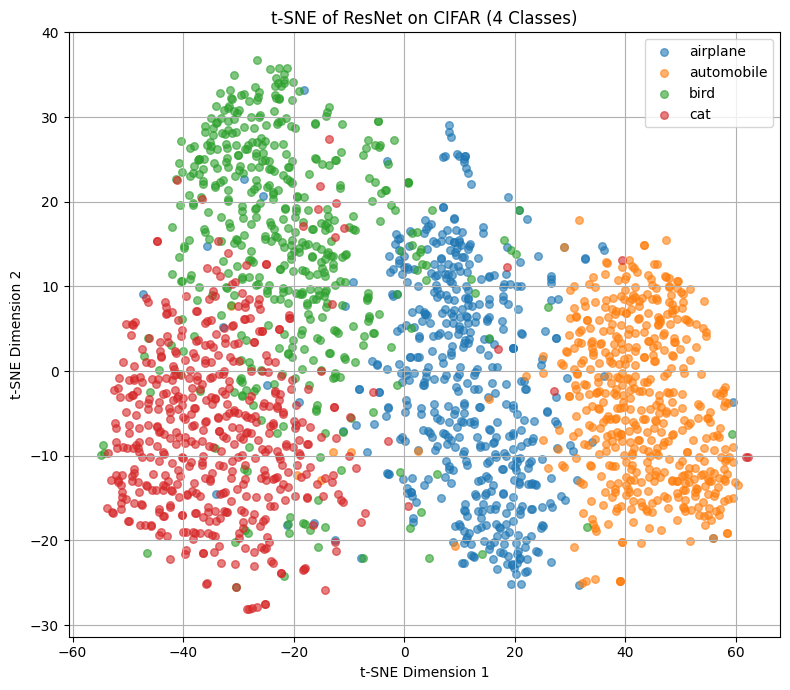


================ TASK 0 ================

Visualizing full 4-class CIFAR embeddings using current model


/tmp/ipykernel_55/3745862970.py:383: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


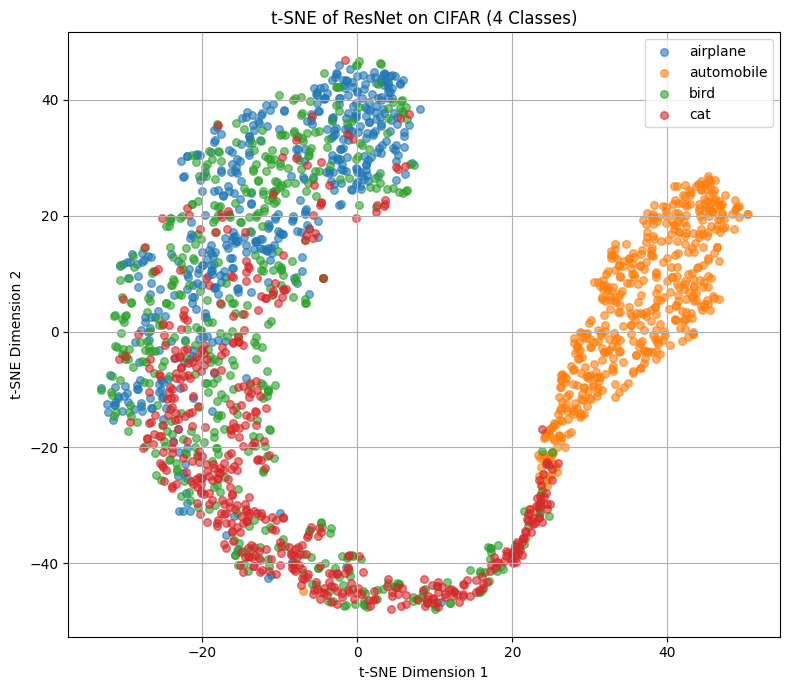

[INIT] Known classes: {'airplane', 'automobile'}

================ TASK 1 ================
[METRIC] Known-Class Acc = 0.972

================ TASK 2 ================
[METRIC] Known-Class Acc = 0.975

================ TASK 3 ================
[METRIC] Known-Class Acc = 0.980

================ TASK 4 ================
Cluster stats → n=74, S_intra=0.017, S_known=0.007, density=4374.8
Cluster stats → n=14, S_intra=0.067, S_known=0.051, density=209.0
[METRIC] Known-Class Acc = 0.983

================ TASK 5 ================
[METRIC] Known-Class Acc = 0.983

================ TASK 6 ================
[METRIC] Known-Class Acc = 0.984

================ TASK 7 ================
[METRIC] Known-Class Acc = 0.984

================ TASK 8 ================
Cluster stats → n=103, S_intra=0.034, S_known=0.015, density=3001.2
Cluster stats → n=38, S_intra=0.076, S_known=0.083, density=498.7
[METRIC] Known-Class Acc = 0.984

================ TASK 9 ================
[METRIC] Known-Class Acc = 0.984

========

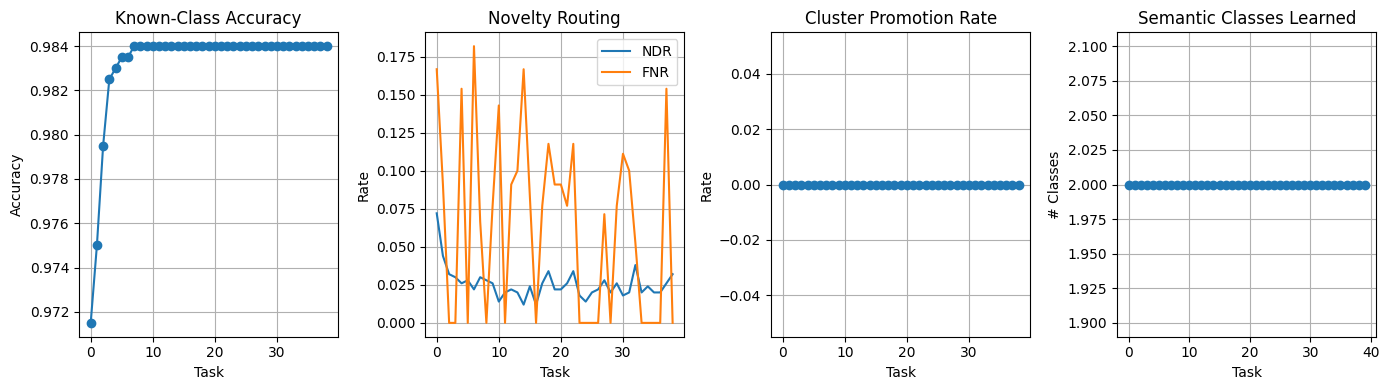

In [9]:
# ============================================================
# OPEN-WORLD LEARNING WITH CLASS DISCOVERY + METRICS
# ============================================================
# This script implements an open-world continual learning system.
#
# Workflow:
# 1. Start with two known classes.
# 2. Train the model on initial task.
# 3. Store raw images in memory for replay.
# 4. Build hypersphere boundaries in embedding space.
# 5. Detect novel samples based on distance from known classes.
# 6. Accumulate high-novelty samples.
# 7. Periodically cluster them using HDBSCAN.
# 8. Validate clusters using geometric criteria.
# 9. Promote valid clusters to new classes.
# 10. Expand classifier head dynamically.
# 11. Fine-tune using replay and prototype regularization.
# 12. Track metrics and visualize embeddings.
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import DataLoader
import hdbscan
from torchvision.models import resnet18
from LabelBench.skeleton.dataset_skeleton import datasets as DATASET_REGISTRY
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA 
import matplotlib.cm as cm


# ============================================================
# CONFIGURATION
# ============================================================

NUM_TASKS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Clustering frequency and novelty buffer configuration
COH_THR = 0.25
SEP_THR = 0.15
P = 4                          # Perform clustering every P tasks
TOPK_NOVELTY = 120             # Keep top novel samples per task
MAX_NOVELTY_BUFFER = 500       # Maximum novelty buffer size
MIN_CLUSTER_SIZE = 50          # Initial definition (overridden below)

# Updated cluster validation thresholds
ALPHA = 0.35                   # Intra-cluster compactness threshold
BETA = 0.25                    # Separation from known classes threshold
DELTA = 40                     # Density threshold
MIN_CLUSTER_SIZE = 30          # Minimum cluster size for promotion


# ============================================================
# CIFAR-10 LABEL MAP
# ============================================================

CIFAR10_LABELS = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
    4: "deer", 5: "dog", 6: "frog", 7: "horse",
    8: "ship", 9: "truck"
}


# ============================================================
# MODEL DEFINITION
# ============================================================

class CNN(nn.Module):
    """
    Model architecture:
    - Pretrained ResNet18 backbone
    - Remove final fully connected layer
    - Projection layer (512 → 256)
    - L2-normalized embedding
    - Linear classifier head
    """

    def __init__(self, num_classes):
        super().__init__()

        base = resnet18(pretrained=True)

        # Remove final fully connected layer
        self.encoder = nn.Sequential(*list(base.children())[:-1])

        # Projection to 256-d embedding
        self.embed = nn.Linear(512, 256)

        # Classification head
        self.classifier = nn.Linear(256, num_classes)

    def expand_head(self, new_classes):
        """
        Expand classifier head while preserving old weights.
        """

        old_w = self.classifier.weight.data.clone()
        old_b = self.classifier.bias.data.clone()
        old_n = old_w.shape[0]

        self.classifier = nn.Linear(256, new_classes)

        # Copy old weights into new head
        self.classifier.weight.data[:old_n] = old_w
        self.classifier.bias.data[:old_n] = old_b

    def forward(self, x):

        # Extract convolutional features
        z = self.encoder(x)

        # Flatten while preserving batch dimension
        z = z.view(z.size(0), -1)

        # Project to embedding space
        z = self.embed(z)

        # Normalize embeddings to unit hypersphere
        z = F.normalize(z, dim=1)

        # Compute logits
        logits = self.classifier(z)

        return logits, z


# ============================================================
# MEMORY BUFFER (Stores RAW IMAGES)
# ============================================================

class MemoryBuffer:
    """
    Stores raw images per class for replay and stability.
    """

    def __init__(self, max_per_class=80):
        self.data = defaultdict(list)
        self.max_per_class = max_per_class

    def add_batch(self, X, y):
        """
        Add raw images for a given class.
        """

        for x in X:
            self.data[int(y)].append(x.detach().cpu())

        # Limit stored samples per class
        if len(self.data[int(y)]) > self.max_per_class:
            self.data[int(y)] = self.data[int(y)][:self.max_per_class]

    def get(self):
        return self.data


# ============================================================
# HYPERSPHERE NOVELTY DETECTOR
# ============================================================

class HypersphereNovelty:
    """
    Each known class is represented by:
    - A centroid in embedding space
    - A quantile-based radius
    """

    def __init__(self, q=0.95):
        self.q = q
        self.mu, self.r = {}, {}

    def update(self, memory, model):
        """
        Recompute class centroids and radii using live embeddings.
        """

        self.mu, self.r = {}, {}

        for k, X in memory.items():

            X = torch.stack(X).to(DEVICE)

            with torch.no_grad():
                _, Z = model(X)

            mu = F.normalize(Z.mean(0), dim=0)
            d = 1 - torch.matmul(Z, mu)

            self.mu[k] = mu
            self.r[k] = torch.quantile(d, self.q)

    def score(self, z):
        """
        Novelty score based on distance from nearest class boundary.
        """

        return min([
            (1 - torch.dot(z, self.mu[k].to(z.device)))
            - self.r[k].to(z.device)
            for k in self.mu
        ])


# ============================================================
# SUPERVISED TRAINING
# ============================================================

def train_supervised(model, loader):

    opt = torch.optim.Adam(model.parameters(), 1e-4)
    model.train()

    for _ in range(15):
        for x, y in loader:

            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)

            loss = F.cross_entropy(model(x)[0], y)

            opt.zero_grad()
            loss.backward()
            opt.step()


# ============================================================
# PROTOTYPE REGULARIZATION LOSS
# ============================================================

def prototype_loss(z, y, detector):

    if len(detector.mu) == 0:
        return torch.tensor(0.0, device=z.device)

    loss = 0.0
    count = 0

    for i in range(len(z)):

        cls = int(y[i].item())

        if cls in detector.mu:
            mu = detector.mu[cls].to(z.device)
            loss += 1 - torch.dot(z[i], mu)
            count += 1

    if count == 0:
        return torch.tensor(0.0, device=z.device)

    return loss / count


# ============================================================
# FINETUNING AFTER PROMOTION
# ============================================================

def finetune(model, memory, X_new, new_label, detector):

    model.train()

    for p in model.parameters():
        p.requires_grad = True

    X_all, Y_all = [], []

    min_count = min(len(v) for v in memory.values())

    for cls, Xs in memory.items():
        for x in Xs[:min_count]:
            X_all.append(x)
            Y_all.append(cls)

    for x in X_new:
        X_all.append(x.cpu())
        Y_all.append(new_label)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=1e-4)

    for _ in range(30):

        logits, Z = model(X_all)

        loss_ce = F.cross_entropy(logits, Y_all)
        loss_proto = prototype_loss(Z, Y_all, detector)

        loss = loss_ce + 0.5 * loss_proto

        opt.zero_grad()
        loss.backward()
        opt.step()

    model.eval()


# ============================================================
# REHEARSAL TRAINING
# ============================================================

def rehearse(model, memory):

    if not memory.get():
        return

    model.train()

    X_all, Y_all = [], []

    for cls, Xs in memory.get().items():
        for x in Xs:
            X_all.append(x)
            Y_all.append(cls)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=5e-4)

    for _ in range(20):

        logits, _ = model(X_all)
        loss = F.cross_entropy(logits, Y_all)

        opt.zero_grad()
        loss.backward()
        opt.step()


# ============================================================
# VISUALIZATION OF FULL 4-CLASS EMBEDDING
# ============================================================

def visualize_full_pretrained(model):

    print("\nVisualizing full 4-class CIFAR embeddings using current model")

    model.eval()

    transform = imagenet_tf

    base_train = tv_datasets.CIFAR10(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    selected_classes = [0, 1, 2, 3]
    targets = np.array(base_train.targets)
    indices = np.where(np.isin(targets, selected_classes))[0]
    subset = Subset(base_train, indices)

    loader = DataLoader(subset, batch_size=128, shuffle=False)

    Z_all, Y_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            _, z = model(x)
            Z_all.append(z.cpu())
            Y_all.append(y)

    Z_all = torch.cat(Z_all).numpy()
    Y_all = torch.cat(Y_all).numpy()

    max_points = 2000
    if len(Z_all) > max_points:
        idx = np.random.choice(len(Z_all), max_points, replace=False)
        Z_all = Z_all[idx]
        Y_all = Y_all[idx]

    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
    Z_tsne = tsne.fit_transform(Z_all)

    plt.figure(figsize=(8, 7))
    cmap = plt.cm.get_cmap("tab10")

    for label in np.unique(Y_all):
        mask = Y_all == label
        plt.scatter(
            Z_tsne[mask, 0],
            Z_tsne[mask, 1],
            s=30,
            alpha=0.6,
            color=cmap(int(label)),
            label=CIFAR10_LABELS[label]
        )

    plt.title("t-SNE of ResNet on CIFAR (4 Classes)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# METRIC STORAGE
# ============================================================

task_kca, task_ndr, task_fnr, task_cpr = [], [], [], []
learned_classes_over_time = []
promoted_classes_log = []


# ============================================================
# MAIN CONTINUAL LEARNING LOOP
# ============================================================

TASKS = [f"splitcifar10_{i}" for i in range(NUM_TASKS)]

model = CNN(num_classes=2).to(DEVICE)
visualize_full_pretrained(model)

memory = MemoryBuffer()
detector = HypersphereNovelty()

novelty_buffer = []

semantic_to_internal = {0: 0, 1: 1}
internal_to_semantic = {0: 0, 1: 1}
known_classes = 2


# ===========================
# Continual Learning Loop
# ===========================

for t, task in enumerate(TASKS):

    print(f"\n================ TASK {t} ================")

    _, dataset_fn = DATASET_REGISTRY[task]
    train_ds, test_ds, *_ = dataset_fn("./data")
    loader = DataLoader(train_ds, batch_size=64, shuffle=False)

    # Initial task training
    if t == 0:

        train_supervised(model, loader)
        visualize_full_pretrained(model)

        with torch.no_grad():
            for x, y in loader:
                y = y.argmax(1)
                for cls in torch.unique(y):
                    memory.add_batch(x[y == cls], cls.item())

        detector.update(memory.get(), model)

        learned_classes_over_time.append(
            {CIFAR10_LABELS[c] for c in set(y.tolist())}
        )

        print(f"[INIT] Known classes: {learned_classes_over_time[-1]}")
        continue

    # Rehearsal phase
    rehearse(model, memory)
    model.eval()

    novelty_candidates = []
    novel, false_novel, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:

            _, z = model(x.to(DEVICE))
            y = y.argmax(1)

            scores = [detector.score(z[i]).item() for i in range(len(z))]

            base_thr = np.percentile(scores, 90)
            thr = base_thr + 0.01 * known_classes

            for i in range(len(z)):

                total += 1

                if scores[i] > thr:

                    novelty_candidates.append(
                        (scores[i], x[i].cpu(), y[i].item())
                    )

                    novel += 1

                    if y[i].item() < known_classes:
                        false_novel += 1

    task_ndr.append(novel / max(total, 1))
    task_fnr.append(false_novel / max(novel, 1))

    novelty_candidates.sort(reverse=True, key=lambda x: x[0])

    novelty_buffer.extend([
        (img, y) for _, img, y in novelty_candidates[:TOPK_NOVELTY]
    ])

    novelty_buffer = novelty_buffer[-MAX_NOVELTY_BUFFER:]

    # Clustering and promotion phase
    if t % P == 0:

        Z = []

        with torch.no_grad():
            for img, _ in novelty_buffer:
                _, z = model(img.unsqueeze(0).to(DEVICE))
                Z.append(z.squeeze().cpu().numpy())

        Z = np.stack(Z)

        labels = hdbscan.HDBSCAN(
            metric='euclidean',
            min_cluster_size=10
        ).fit_predict(Z)

        new_buffer = []
        found, promoted = 0, 0

        for cid in sorted(set(labels)):

            idxs = np.where(labels == cid)[0]

            if cid == -1:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])
                continue

            found += 1

            Xc = torch.stack([novelty_buffer[i][0] for i in idxs])

            with torch.no_grad():
                _, Zc = model(Xc.to(DEVICE))

            mu = F.normalize(Zc.mean(0), dim=0)
            n = len(idxs)

            S_intra = torch.mean(1 - torch.matmul(Zc, mu))

            if len(detector.mu) > 0:
                S_known = min([
                    1 - torch.dot(mu, detector.mu[k].to(mu.device))
                    for k in detector.mu
                ])
            else:
                S_known = torch.tensor(1.0)

            density = n / (S_intra.item() + 1e-6)

            labels_true = [novelty_buffer[i][1] for i in idxs]
            sem_label, cnt = Counter(labels_true).most_common(1)[0]
            purity = cnt / len(labels_true)

            if sem_label in semantic_to_internal:
                continue

            print(
                f"Cluster stats → "
                f"n={n}, "
                f"S_intra={S_intra.item():.3f}, "
                f"S_known={S_known.item():.3f}, "
                f"density={density:.1f}"
            )

            if (
                S_intra <= ALPHA and
                density >= DELTA and
                S_known >= BETA and
                n >= MIN_CLUSTER_SIZE
            ):

                promoted += 1
                new_label = known_classes

                semantic_to_internal[sem_label] = new_label
                internal_to_semantic[new_label] = sem_label
                known_classes += 1

                model.expand_head(known_classes)
                model.to(DEVICE)

                finetune(model, memory.get(), Xc, new_label, detector)
                memory.add_batch(Xc, new_label)

                detector.update(memory.get(), model)

                promoted_classes_log.append({
                    "task": t,
                    "semantic": CIFAR10_LABELS[sem_label],
                    "purity": purity
                })

                print(f"PROMOTED → {CIFAR10_LABELS[sem_label]}")

            else:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])

        novelty_buffer = new_buffer
        task_cpr.append(promoted / max(found, 1))

    else:
        task_cpr.append(0.0)

    # ========================================================
    # TASK-WISE EVALUATION
    # ========================================================

    learned_classes_over_time.append(
        set(learned_classes_over_time[-1])
        if len(learned_classes_over_time) > 0 else set()
    )

    for p in promoted_classes_log:
        if p["task"] == t:
            learned_classes_over_time[-1].add(p["semantic"])

    correct, total_eval = 0, 0

    with torch.no_grad():
        for x_test, y_test in DataLoader(test_ds, batch_size=128):

            x_test = x_test.to(DEVICE)
            y_test = y_test.argmax(1).to(DEVICE)

            logits, _ = model(x_test)
            preds = logits.argmax(1)

            for i in range(len(y_test)):

                sem = int(y_test[i])

                if sem in semantic_to_internal:

                    internal_gt = semantic_to_internal[sem]

                    if preds[i].item() == internal_gt:
                        correct += 1

                    total_eval += 1

    acc = correct / max(total_eval, 1)
    task_kca.append(acc)

    print(f"[METRIC] Known-Class Acc = {acc:.3f}")


# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n===== FINAL DISCOVERY SUMMARY =====")

if len(learned_classes_over_time) > 0:
    print("Initial classes:", learned_classes_over_time[0])
    print("Final learned classes:", learned_classes_over_time[-1])

print("\nPromoted classes timeline:")
for p in promoted_classes_log:
    print(f"Task {p['task']:02d} → {p['semantic']} (purity={p['purity']:.2f})")


# ============================================================
# VISUALIZATION OF METRICS
# ============================================================

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(task_kca, marker='o')
plt.title("Known-Class Accuracy")
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1,4,2)
plt.plot(task_ndr, label="NDR")
plt.plot(task_fnr, label="FNR")
plt.title("Novelty Routing")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)

plt.subplot(1,4,3)
plt.plot(task_cpr, marker='o')
plt.title("Cluster Promotion Rate")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.grid(True)

plt.subplot(1,4,4)
plt.plot([len(set_) for set_ in learned_classes_over_time], marker='o')
plt.title("Semantic Classes Learned")
plt.xlabel("Task")
plt.ylabel("# Classes")
plt.grid(True)

plt.tight_layout()
plt.show()


## retrying refinement in the code

In [ ]:
# ============================================================
# OPEN-WORLD LEARNING WITH CLASS DISCOVERY (Paper-Aligned)
# ============================================================
#
# This implementation follows a two-stage open-world learning framework:
#
# STAGE I  : OOD-Aware Routing using hypersphere novelty detection
# STAGE II : Clustering and Confirmation using HDBSCAN
#
# Core ideas:
# - Use ImageNet pretrained ResNet18 backbone
# - Work in cosine embedding space (L2 normalized features)
# - Maintain class prototypes and radii (Eq 6, Eq 7)
# - Route samples as novel if outside hyperspheres (Eq 4)
# - Cluster novel samples periodically
# - Validate clusters using cohesion & separation (Eq 9–11)
# - Dynamically expand classifier
# - Prevent catastrophic forgetting via replay + differential LR
#
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import DataLoader
import hdbscan
from sklearn.manifold import TSNE
from torchvision.models import resnet18, ResNet18_Weights

# -------------------------------------------------------------------
# Dataset registry (ensure correct path configuration in your system)
# -------------------------------------------------------------------
from LabelBench.skeleton.dataset_skeleton import datasets as DATASET_REGISTRY


# ============================================================
# CONFIGURATION & THRESHOLDS (Cosine Space Tuned)
# ============================================================

NUM_TASKS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Frequency of clustering stage
P = 4

# Novelty buffer controls
TOPK_NOVELTY = 120
MAX_NOVELTY_BUFFER = 500

# Minimum cluster size for HDBSCAN
MIN_CLUSTER_SIZE = 10

# ------------------------------------------------------------
# PAPER-ALIGNED THRESHOLDS
# ------------------------------------------------------------
# Q_QUANTILE → Eq 6 (class radius)
# ALPHA      → Eq 9 (cohesion threshold)
# BETA       → Eq 11 (separation margin)
# ------------------------------------------------------------

Q_QUANTILE = 0.95
ALPHA = 0.40
BETA = -0.25


# ============================================================
# CIFAR-10 LABEL MAP
# ============================================================

CIFAR10_LABELS = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
    4: "deer", 5: "dog", 6: "frog", 7: "horse",
    8: "ship", 9: "truck"
}


# ============================================================
# MODEL ARCHITECTURE (Paper-Aligned)
# ============================================================

class CNN(nn.Module):
    """
    Model Design:
    - ImageNet pretrained ResNet18
    - Modified for CIFAR resolution
    - No extra projection layer
    - Use full 512D feature embedding
    - Cosine distance computed on L2-normalized embeddings
    """

    def __init__(self, num_classes):
        super().__init__()

        weights = ResNet18_Weights.IMAGENET1K_V1
        base = resnet18(weights=weights)

        # CIFAR-10 Adaptation:
        # Replace large 7x7 conv with smaller 3x3
        base.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )

        # Remove initial maxpool layer
        base.maxpool = nn.Identity()

        # Remove final classification layer
        self.encoder = nn.Sequential(*list(base.children())[:-1])

        # Linear classifier using 512D features
        self.classifier = nn.Linear(512, num_classes,bias=False)
        self.sigma = 15.0

    def expand_head(self, new_classes):
        """
        Expand classification head when a new class is discovered.
        Old weights are preserved.
        """

        old_w = self.classifier.weight.data.clone()
        old_b = self.classifier.bias.data.clone()
        old_n = old_w.shape[0]

        self.classifier = nn.Linear(512, new_classes)

        self.classifier.weight.data[:old_n] = old_w
        # self.classifier.bias.data[:old_n] = old_b
        if new_weight is not None:
            self.classifier.weight.data[-1] = new_weight

    def forward(self, x):

        # Extract raw 512D features
        z_raw = self.encoder(x)
        z_raw = z_raw.view(z_raw.size(0), -1)
        z_norm = F.normalize(z_raw, dim=1)
        w_norm = F.normalize(self.classifier.weight, dim=1)
        logits = F.linear(z_norm, w_norm) * self.sigma
        # # Classification logits
        # logits = self.classifier(z_raw)

        # # L2-normalized embeddings for cosine geometry
        # z_norm = F.normalize(z_raw, dim=1)

        return logits, z_norm


# ============================================================
# MEMORY BUFFER
# ============================================================

class MemoryBuffer:
    """
    Stores raw images for each known class.
    Used for:
    - Rehearsal
    - Prototype estimation
    - Catastrophic forgetting mitigation
    """

    def __init__(self, max_per_class=80):
        self.data = defaultdict(list)
        self.max_per_class = max_per_class

    def add_batch(self, X, y):
        for x in X:
            self.data[int(y)].append(x.detach().cpu())

        # Enforce memory limit
        if len(self.data[int(y)]) > self.max_per_class:
            self.data[int(y)] = self.data[int(y)][:self.max_per_class]

    def get(self):
        return self.data


# ============================================================
# STAGE I: OOD-AWARE ROUTING (Eq 4–6)
# ============================================================

class HypersphereNovelty:
    """
    Maintains:
    - Class prototype μ_k (Eq 7)
    - Class radius r_k (Eq 6)
    """

    def __init__(self, q=Q_QUANTILE):
        self.q = q
        self.mu, self.r = {}, {}

    def update(self, memory, model):

        self.mu, self.r = {}, {}

        for k, X in memory.items():

            X = torch.stack(X).to(DEVICE)

            with torch.no_grad():
                _, Z_norm = model(X)

            # Prototype (Eq 7)
            mu = F.normalize(Z_norm.mean(0), dim=0)

            # Radius (Eq 6)
            d = 1 - torch.matmul(Z_norm, mu)

            self.mu[k] = mu
            self.r[k] = torch.quantile(d, self.q)

    def score(self, z_norm):
        """
        Novelty score (Eq 4):
        s(x) = min_k (distance(z, μ_k) - r_k)
        """

        if len(self.mu) == 0:
            return 0.0

        return min([
            (1 - torch.dot(z_norm, self.mu[k].to(z_norm.device)))
            - self.r[k].to(z_norm.device)
            for k in self.mu
        ])


# ============================================================
# PROTOTYPE REGULARIZATION
# ============================================================

def prototype_loss(z_norm, y, detector):
    """
    Encourages embeddings to remain close to known prototypes.
    """

    if len(detector.mu) == 0:
        return torch.tensor(0.0, device=z_norm.device)

    loss = 0.0
    count = 0

    for i in range(len(z_norm)):
        cls = int(y[i].item())
        if cls in detector.mu:
            mu = detector.mu[cls].to(z_norm.device)
            loss += 1 - torch.dot(z_norm[i], mu)
            count += 1

    if count == 0:
        return torch.tensor(0.0, device=z_norm.device)

    return loss / count


# ============================================================
# TRAINING UTILITIES (Differential Learning Rates)
# ============================================================

def train_supervised(model, loader):

    model.train()

    # Protect backbone (very small LR)
    opt = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': 1e-6},
        {'params': model.classifier.parameters(), 'lr': 1e-4}
    ])

    for _ in range(15):
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)

            logits, _ = model(x)
            loss = F.cross_entropy(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()


def finetune(model, memory, X_new, new_label, detector):

    model.train()

    for p in model.encoder.parameters():
        p.requires_grad = True

    for p in model.classifier.parameters():
        p.requires_grad = True

    X_all, Y_all = [], []
    min_count = min(len(v) for v in memory.values())

    for cls, Xs in memory.items():
        for x in Xs[:min_count]:
            X_all.append(x)
            Y_all.append(cls)

    for x in X_new:
        X_all.append(x.cpu())
        Y_all.append(new_label)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': 1e-6},
        {'params': model.classifier.parameters(), 'lr': 1e-4}
    ])

    for _ in range(15):
        logits, Z_norm = model(X_all)
        loss_ce = F.cross_entropy(logits, Y_all)
        loss_proto = prototype_loss(Z_norm, Y_all, detector)
        loss = loss_ce + 0.5 * loss_proto

        opt.zero_grad()
        loss.backward()
        opt.step()

    model.eval()


def rehearse(model, memory):

    if not memory.get():
        return

    model.train()

    X_all, Y_all = [], []

    for cls, Xs in memory.get().items():
        for x in Xs:
            X_all.append(x)
            Y_all.append(cls)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': 1e-6},
        {'params': model.classifier.parameters(), 'lr': 1e-4}
    ])

    for _ in range(5):
        logits, _ = model(X_all)
        loss = F.cross_entropy(logits, Y_all)

        opt.zero_grad()
        loss.backward()
        opt.step()


# ============================================================
# MAIN LOOP
# ============================================================

task_kca, task_ndr, task_fnr, task_cpr = [], [], [], []
learned_classes_over_time = []
promoted_classes_log = []

TASKS = [f"splitcifar10_{i}" for i in range(NUM_TASKS)]

model = CNN(num_classes=2).to(DEVICE)
# visualize_full_pretrained(model)
memory = MemoryBuffer()
detector = HypersphereNovelty(q=Q_QUANTILE)

novelty_buffer = []
semantic_to_internal = {0: 0, 1: 1}
known_classes = 2


# ============================================================
# CONTINUAL LEARNING LOOP
# ============================================================

for t, task in enumerate(TASKS):

    print(f"\n================ TASK {t} ================")

    _, dataset_fn = DATASET_REGISTRY[task]
    train_ds, test_ds, *_ = dataset_fn("./data")
    loader = DataLoader(train_ds, batch_size=64, shuffle=False)

    # INITIAL TRAINING
    if t == 0:

        train_supervised(model, loader)
        # visualize_full_pretrained(model)
        with torch.no_grad():
            for x, y in loader:
                y = y.argmax(1)
                for cls in torch.unique(y):
                    memory.add_batch(x[y == cls], cls.item())

        detector.update(memory.get(), model)

        learned_classes_over_time.append(
            {CIFAR10_LABELS[c] for c in set(y.tolist())}
        )

        print(f"[INIT] Known classes: {learned_classes_over_time[-1]}")
        continue

    rehearse(model, memory)
    model.eval()

    novelty_candidates = []
    novel, false_novel, total = 0, 0, 0

    # ---------------- STAGE I: ROUTING ----------------
    with torch.no_grad():
        for x, y in loader:

            _, z_norm = model(x.to(DEVICE))
            y = y.argmax(1)

            scores = [
                detector.score(z_norm[i]).item()
                for i in range(len(z_norm))
            ]

            for i in range(len(z_norm)):

                total += 1

                # Decision rule (Section 6.1)
                if scores[i] > 0.0:

                    novelty_candidates.append(
                        (scores[i], x[i].cpu(), y[i].item())
                    )

                    novel += 1

                    if y[i].item() < known_classes:
                        false_novel += 1

    task_ndr.append(novel / max(total, 1))
    task_fnr.append(false_novel / max(novel, 1))

    novelty_candidates.sort(reverse=True, key=lambda x: x[0])

    novelty_buffer.extend([
        (img, y) for _, img, y in novelty_candidates[:TOPK_NOVELTY]
    ])

    novelty_buffer = novelty_buffer[-MAX_NOVELTY_BUFFER:]

    # ---------------- STAGE II: CLUSTERING ----------------
    if t % P == 0:

        Z_raw = []

        with torch.no_grad():
            for img, _ in novelty_buffer:
                _, z_norm = model(img.unsqueeze(0).to(DEVICE))
                Z_raw.append(z_norm.squeeze().cpu().numpy())

        if len(Z_raw) == 0:
            task_cpr.append(0.0)
        else:

            Z_raw = np.stack(Z_raw).astype(np.float64)

            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=MIN_CLUSTER_SIZE,
                min_samples=2,
                metric='euclidean',
                cluster_selection_method='leaf',
                allow_single_cluster=False
            )

            labels = clusterer.fit_predict(Z_raw)

            unique_labels = sorted(set(labels))
            print(f"[DEBUG] Clusters found: {unique_labels} (counts: {dict(Counter(labels))})")

            new_buffer = []
            found, promoted = 0, 0

            for cid in unique_labels:

                idxs = np.where(labels == cid)[0]

                if cid == -1:
                    for i in idxs:
                        new_buffer.append(novelty_buffer[i])
                    continue

                found += 1

                Xc = torch.stack([novelty_buffer[i][0] for i in idxs])

                with torch.no_grad():
                    _, Zc = model(Xc.to(DEVICE))

                mu_C = F.normalize(Zc.mean(0), dim=0)

                d_x = 1 - torch.matmul(Zc, mu_C)
                S_coh = torch.quantile(d_x, 0.90)

                if len(detector.mu) > 0:
                    Delta_C = min([
                        (1 - torch.dot(mu_C, detector.mu[k].to(mu_C.device)))
                        - detector.r[k].to(mu_C.device)
                        for k in detector.mu
                    ])
                else:
                    Delta_C = torch.tensor(1.0)

                n = len(idxs)

                labels_true = [novelty_buffer[i][1] for i in idxs]
                sem_label, cnt = Counter(labels_true).most_common(1)[0]
                purity = cnt / len(labels_true)

                print(f"   [DEBUG] Purity: {purity:.2f} (Dominant Class: {CIFAR10_LABELS.get(sem_label, str(sem_label))})")

                if sem_label in semantic_to_internal:
                    continue

                print(f"Cluster stats → n={n}, S_coh={S_coh.item():.3f}, Delta_C={Delta_C.item():.3f}")

                if (
                    S_coh.item() <= ALPHA and
                    Delta_C.item() >= BETA and
                    n >= MIN_CLUSTER_SIZE
                ):

                    promoted += 1
                    new_label = known_classes

                    semantic_to_internal[sem_label] = new_label
                    known_classes += 1

                    # model.expand_head(known_classes)
                    # model.to(DEVICE)
                    model.expand_head(known_classes, new_weight=mu_C)
                    model.to(DEVICE)

                    finetune(model, memory.get(), Xc, new_label, detector)
                    memory.add_batch(Xc, new_label)

                    detector.update(memory.get(), model)

                    promoted_classes_log.append({
                        "task": t,
                        "semantic": CIFAR10_LABELS[sem_label],
                        "purity": purity
                    })

                    print(f"🎉 PROMOTED → {CIFAR10_LABELS[sem_label]}")

                else:
                    for i in idxs:
                        new_buffer.append(novelty_buffer[i])

            novelty_buffer = new_buffer
            task_cpr.append(promoted / max(found, 1))

    else:
        task_cpr.append(0.0)

    # ---------------- EVALUATION ----------------

    learned_classes_over_time.append(
        set(learned_classes_over_time[-1])
        if len(learned_classes_over_time) > 0 else set()
    )

    for p in promoted_classes_log:
        if p["task"] == t:
            learned_classes_over_time[-1].add(p["semantic"])

    correct, total_eval = 0, 0

    with torch.no_grad():
        for x_test, y_test in DataLoader(test_ds, batch_size=128):

            x_test = x_test.to(DEVICE)
            y_test = y_test.argmax(1).to(DEVICE)

            logits, _ = model(x_test)
            preds = logits.argmax(1)

            for i in range(len(y_test)):

                sem = int(y_test[i])

                if sem in semantic_to_internal:

                    internal_gt = semantic_to_internal[sem]

                    if preds[i].item() == internal_gt:
                        correct += 1

                    total_eval += 1

    acc = correct / max(total_eval, 1)
    task_kca.append(acc)

    print(f"[METRIC] Known-Class Acc = {acc:.3f}")


# ============================================================
# FINAL SUMMARY & PLOTS
# ============================================================

print("\n===== FINAL DISCOVERY SUMMARY =====")

if len(learned_classes_over_time) > 0:
    print("Initial classes:", learned_classes_over_time[0])
    print("Final learned classes:", learned_classes_over_time[-1])

print("\nPromoted classes timeline:")
for p in promoted_classes_log:
    print(f"Task {p['task']:02d} → {p['semantic']} (purity={p['purity']:.2f})")

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(task_kca, marker='o')
plt.title("Known-Class Accuracy")
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1,4,2)
plt.plot(task_ndr, label="NDR")
plt.plot(task_fnr, label="FNR")
plt.title("Novelty Routing")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)

plt.subplot(1,4,3)
plt.plot(task_cpr, marker='o')
plt.title("Cluster Promotion Rate")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.grid(True)

plt.subplot(1,4,4)
plt.plot([len(set_) for set_ in learned_classes_over_time], marker='o')
plt.title("Semantic Classes Learned")
plt.xlabel("Task")
plt.ylabel("# Classes")
plt.grid(True)

plt.tight_layout()
plt.show()



================ TASK 0 ================
